In this group of notebook we will test the methods implemented in the library to check if they can improve the results of the models.

In order to be as impartial as possible, we will use a KFold evaluation for each combination, with a k-value of five.

In this particular notebook, we will train the model using the `RICAP` technique.

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from semantic_segmentation_augmentations.holemakertechnique import HoleMakerPoint
from semantic_segmentation_augmentations.holesfilling import RICAP

from vision_models_evaluation.core import evaluate

from sklearn.model_selection import KFold

import pandas as pd

import matplotlib.pyplot as plt

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch; torch.cuda.set_device(1)

Then, we prepare the scenario: we are going to use a grape vine dataset where the semantic problem to tackle is to segmentate the RGB images into wood, leaves, grape and pole classes.

Finally, we define here the mapping functions and the masks transformations.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"

def get_y_fn(x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        if len(x) == 2:
            img, mask = x
        elif len(x) == 1:
            img = x[0]
            mask = np.zeros_like(img)

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask
    
def decodes(mask):
    shape = mask.shape
    _mask = np.empty([*shape, 3])
    grape_c = np.array([255, 255, 255])
    leaves_c = np.array([0, 255, 0])
    pole_c = np.array([255, 0, 0])
    wood_c = np.array([0, 0, 255])
    back_c = np.array([0, 0, 0])
    
    for j in range(shape[0]):
        for i in range(shape[1]):
            if mask[j, i] == 1:
                _mask[j, i] = grape_c
            elif mask[j, i] == 2:
                _mask[j, i] = leaves_c
            elif mask[j, i] == 3:
                _mask[j, i] = pole_c
            elif mask[j, i] == 4:
                _mask[j, i] = wood_c
            else:
                _mask[j, i] = back_c
    
    return _mask.astype(np.uint8)

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

While training, we will use the EarlyStopping strategy: after five epoch without improvements, the training will be stopped.

In [ ]:
esc = EarlyStoppingCallback(patience = 5, min_delta = 0.01)

Then, we define all the hparams (hyperparameters) to build the datablocks, dataloaders and learners.

In [ ]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": get_image_files,
    "get_y": get_y_fn,
    "splitter": RandomSplitter(valid_pct=0.2),
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}

dls_hparams = {
    "source": path_images,
    "bs": 2,
    "pin_memory": False
}

technique = KFold(n_splits = 5)

learner_hparams = {
    "arch": resnet50,
    "pretrained": True,
    "metrics": [DiceMulti()],
    "cbs": []
}

learning_hparams = {
    "epochs": 30,
    "base_lr": 0.001,
    "freeze_epochs": 3
}

learning_mode = "finetune"

saving_hparams = {
    "save_best": True,
    "metric": "DiceMulti",
    "model_name": "RICAP"
}

In order to know how does this technique work, we can show an example:

This technique divides the image (and its mask) in four regions and shuffles them. Those regions are selected randomly as the cross point is selected too. `t` and `u` hparams (_[0, 0.5)_) allows to move the cross point to another region of the image. `t` reduces the region to the center and `u`, if used, reduces the region to the corners. Those hparams can not be used at the same time.

The only technique that makes sense to use in this case is the `HoleMakerPoint`.

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


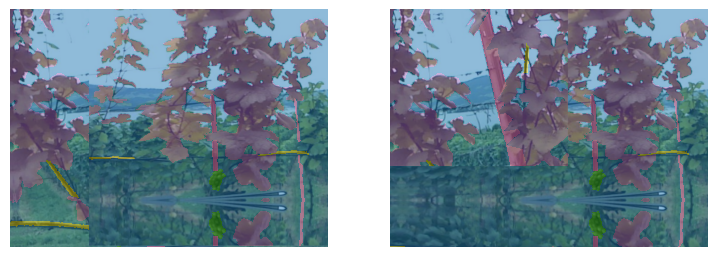

In [ ]:
cmr = RICAP(t = 0.25, p = 1)
dls = DataBlock(**db_hparams).dataloaders(**dls_hparams)
with Learner(dls, resnet50(), metrics=[DiceMulti()], cbs = cmr) as learn:
    learn.epoch, learn.training = 0, True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_, axs = plt.subplots(1, 2, figsize=(9, 9))
dls.show_batch(b = (cmr.x, cmr.y), ctxs = axs.flatten())

Finally, we test the model with distinct hparams.

In [ ]:
results = {}

for t, u in [(0, None), (0.2, None), (0.4, None), (None, 0.2), (None, 0.4)]:
    cmr = RICAP(t = t, u = u)
    learner_hparams["cbs"] = [esc, cmr]
    r = evaluate(db_hparams,
                 dls_hparams,
                 technique,
                 learner_hparams,
                 learning_hparams,
                 learning_mode,
                 saving_hparams,
                 verbose = True
                )
    results.update({
        str(t) + str(u): r["DiceMulti"]
    })

Starting the training for a new model
Training the fold 1


/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,dice_multi,time
0,0.900210,0.604107,0.348343,00:22
1,0.736100,0.569922,0.344968,00:20
2,0.648220,0.497807,0.369307,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.447793,0.386789,0.394996,00:20
1,0.428260,0.381193,0.485861,00:20
2,0.391091,0.318343,0.615196,00:20
3,0.379951,0.332191,0.710167,00:20
4,0.368413,0.348888,0.639932,00:20
5,0.356932,0.536880,0.628508,00:20
6,0.343502,0.336115,0.758238,00:20
7,0.340069,0.278954,0.770210,00:20
8,0.323822,0.258898,0.812157,00:20
9,0.311529,0.294532,0.748284,00:20


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.22738683223724365  /  DiceMulti: 0.8028776070610473  
Saving best model because DiceMulti 0.8029 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.867498,0.767222,0.304908,00:20
1,0.677837,0.481169,0.370565,00:20
2,0.577401,0.457736,0.415343,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.401764,0.365641,0.429766,00:21
1,0.368302,0.302383,0.671351,00:21
2,0.341859,0.311938,0.691358,00:21
3,0.334092,0.324801,0.716515,00:20
4,0.328989,0.325996,0.756124,00:21
5,0.319631,0.322495,0.710607,00:21
6,0.308252,0.284772,0.798297,00:20
7,0.392544,0.329173,0.678837,00:20
8,0.378211,0.299152,0.782148,00:21
9,0.340923,0.264098,0.801526,00:20


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.22910566627979279  /  DiceMulti: 0.8048014084846103  
Saving best model because DiceMulti 0.8048 >= 0.8029.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.079319,0.630222,0.337587,00:20
1,0.788279,0.536027,0.344843,00:20
2,1.201058,0.711539,0.314066,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.523852,0.407670,0.373574,00:21
1,0.469381,0.379988,0.435557,00:21
2,0.427655,0.349382,0.516576,00:20
3,0.401913,0.350558,0.632421,00:20
4,0.374252,0.320870,0.667599,00:20
5,0.349586,0.339217,0.726863,00:20
6,0.345447,0.291900,0.744881,00:21
7,0.316621,0.278497,0.796881,00:20
8,0.297449,0.269025,0.785778,00:20
9,0.293703,0.308824,0.803194,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.21895891427993774  /  DiceMulti: 0.8418914951722056  
Saving best model because DiceMulti 0.8419 >= 0.8048.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.958436,1.366927,0.235247,00:20
1,0.810172,0.514460,0.348258,00:20
2,0.779585,0.409006,0.356039,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.434604,0.326870,0.573660,00:21
1,0.403820,0.289003,0.671537,00:21
2,0.377123,0.265833,0.681846,00:20
3,0.362910,0.311158,0.721093,00:21
4,0.359310,0.269614,0.756328,00:21
5,0.354439,0.347080,0.515232,00:20
6,0.360017,0.285264,0.730841,00:20
7,0.350542,0.225492,0.793113,00:20
8,0.334866,0.235193,0.790865,00:20
9,0.322226,0.231090,0.811309,00:20


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.2288438081741333  /  DiceMulti: 0.8368793885742167  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.849487,0.609574,0.345856,00:20
1,0.678039,0.593284,0.340862,00:21
2,1.031822,0.836898,0.251384,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.570483,0.502697,0.350794,00:21
1,0.488730,0.445381,0.397733,00:21
2,0.436365,0.353621,0.441596,00:21
3,0.389855,0.317353,0.693515,00:21
4,0.364517,0.314984,0.737349,00:21
5,0.357358,0.293600,0.758736,00:21
6,0.341144,0.326979,0.680364,00:21
7,0.322420,0.265895,0.795375,00:21
8,0.307856,0.271289,0.796512,00:21
9,0.300870,0.274028,0.797723,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.29381006956100464  /  DiceMulti: 0.7750628460422753  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.979201,0.623804,0.310573,00:20
1,0.716537,0.540162,0.358763,00:20
2,0.598682,0.651569,0.482387,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.385096,0.445612,0.566840,00:21
1,0.355759,0.488516,0.601482,00:21
2,0.339798,0.411263,0.648024,00:21
3,0.327499,0.405075,0.685093,00:21
4,0.314090,0.406813,0.673745,00:21
5,0.310217,0.454689,0.635267,00:21
6,0.301992,0.391269,0.709219,00:21
7,0.288070,0.450782,0.694696,00:21
8,0.287334,0.443568,0.685281,00:21
9,0.268008,0.376356,0.699629,00:21


No improvement since epoch 9: early stopping


Test results for the model.   validation: 0.19604027271270752  /  DiceMulti: 0.8428638695781656  
Saving best model because DiceMulti 0.8429 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.921578,0.506327,0.351363,00:20
1,0.666582,0.418520,0.407093,00:21
2,0.708942,0.809814,0.254240,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.489766,0.415301,0.437094,00:21
1,0.433583,0.364809,0.501658,00:21
2,0.397195,0.334981,0.571951,00:21
3,0.362095,0.297255,0.667282,00:21
4,0.346862,0.451345,0.590668,00:21
5,0.342003,0.339065,0.764886,00:21
6,0.371340,0.408375,0.627489,00:21
7,0.377066,0.298472,0.753682,00:21
8,0.348596,0.269922,0.800450,00:21
9,0.334179,0.285433,0.763214,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.26685431599617004  /  DiceMulti: 0.8030238164487518  
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.812959,0.621393,0.336422,00:20
1,0.751279,0.548189,0.334094,00:20
2,0.647248,0.462794,0.346912,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.446169,0.387270,0.482466,00:21
1,0.413709,0.357592,0.519274,00:21
2,0.387861,0.324251,0.616314,00:21
3,0.362324,0.350209,0.697336,00:21
4,0.343728,0.384254,0.566122,00:21
5,0.355106,0.303785,0.750958,00:20
6,0.338881,0.311159,0.769440,00:21
7,0.325951,0.286879,0.754602,00:21
8,0.326580,0.311528,0.761525,00:21
9,0.310598,0.280016,0.771493,00:21


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.17490358650684357  /  DiceMulti: 0.852226441073541  
Saving best model because DiceMulti 0.8522 >= 0.8429.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.987913,0.549286,0.355589,00:20
1,0.702786,0.370678,0.359370,00:21
2,0.659568,0.429386,0.354672,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.435703,0.300160,0.585504,00:21
1,0.404256,0.275457,0.707920,00:21
2,0.374497,0.276091,0.634106,00:21
3,0.360906,0.288636,0.736613,00:21
4,0.351572,0.325144,0.732352,00:21
5,0.371178,0.308930,0.796669,00:21
6,0.354074,0.294288,0.795706,00:21


No improvement since epoch 1: early stopping


Test results for the model.   validation: 0.3042529225349426  /  DiceMulti: 0.8105333362365537  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.003046,0.647151,0.337344,00:20
1,0.680554,0.457851,0.402496,00:21
2,0.594416,0.694547,0.314176,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.413035,0.379589,0.567918,00:21
1,0.400254,0.332486,0.695073,00:21
2,0.365282,0.292058,0.755897,00:21
3,0.344980,0.304832,0.783541,00:21
4,0.321875,0.297814,0.733158,00:21
5,0.324767,0.316461,0.764990,00:21
6,0.319715,0.407193,0.742769,00:21
7,0.331061,0.319458,0.752412,00:21


No improvement since epoch 2: early stopping


Test results for the model.   validation: 0.38286292552948  /  DiceMulti: 0.7064157942125802  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.878634,0.732372,0.307859,00:21
1,0.660161,0.509925,0.418798,00:21
2,0.591411,0.604503,0.325972,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.406578,0.443561,0.542324,00:21
1,0.363837,0.430110,0.632221,00:21
2,0.343329,0.500095,0.646166,00:21
3,0.317971,0.433027,0.687449,00:21
4,0.308005,0.442809,0.657768,00:21
5,0.294315,0.388410,0.678629,00:21
6,0.288149,0.416691,0.613026,00:21
7,0.284349,0.390574,0.703156,00:21
8,0.284887,0.422701,0.721092,00:21
9,0.273576,0.392056,0.717661,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.18826615810394287  /  DiceMulti: 0.8576496373799962  
Saving best model because DiceMulti 0.8576 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,0.972413,0.729063,0.303909,00:21
1,0.708177,0.540774,0.353180,00:21
2,0.635601,0.438238,0.350675,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.435027,0.419020,0.485022,00:21
1,0.413655,0.356109,0.531986,00:21
2,0.392265,0.319261,0.730503,00:21
3,0.371716,0.335957,0.755248,00:21
4,0.356477,0.333051,0.718399,00:21
5,0.349179,0.279906,0.777209,00:21
6,0.339816,0.298554,0.753065,00:21
7,0.342240,0.344505,0.701556,00:21
8,0.320817,0.300735,0.767747,00:21
9,0.301525,0.390408,0.714671,00:21


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.1862190067768097  /  DiceMulti: 0.868655532960879  
Saving best model because DiceMulti 0.8687 >= 0.8576.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.126284,0.918249,0.246807,00:20
1,0.847125,0.501846,0.340417,00:21
2,0.681447,0.493918,0.342362,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.423497,0.372409,0.408929,00:21
1,0.393555,0.341814,0.560629,00:21
2,0.389835,0.331063,0.644131,00:21
3,0.363083,0.333019,0.720527,00:21
4,0.357632,0.303706,0.727378,00:21
5,0.336828,0.297688,0.754872,00:21
6,0.328538,0.305065,0.739466,00:21
7,0.340179,0.308652,0.757036,00:21
8,0.326651,0.279764,0.789348,00:21
9,0.304776,0.274104,0.812102,00:21


No improvement since epoch 10: early stopping


Test results for the model.   validation: 0.1859499216079712  /  DiceMulti: 0.8562865680559308  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,1.048451,0.688156,0.308880,00:21
1,0.719721,0.411208,0.371489,00:21
2,0.652819,0.801589,0.342235,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.494264,0.351824,0.521898,00:21
1,0.445160,0.285313,0.599212,00:21
2,0.401551,0.278875,0.729484,00:21
3,0.378995,0.268112,0.723697,00:21
4,0.359774,0.260463,0.783816,00:21
5,0.348210,0.292154,0.761008,00:21
6,0.331832,0.234654,0.775860,00:21
7,0.333737,0.254037,0.732754,00:21
8,0.330643,0.228899,0.778837,00:21
9,0.331316,0.235062,0.810793,00:21


No improvement since epoch 15: early stopping


Test results for the model.   validation: 0.1726335883140564  /  DiceMulti: 0.8779001990943366  
Saving best model because DiceMulti 0.8779 >= 0.8687.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,1.007300,0.932671,0.304517,00:21
1,0.734834,0.630591,0.344323,00:21
2,0.630804,1.083604,0.190142,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.496571,0.447209,0.396714,00:21
1,0.457260,0.390632,0.539067,00:21
2,0.415622,0.395519,0.590190,00:21
3,0.386224,0.311782,0.692874,00:21
4,0.355764,0.327430,0.609227,00:21
5,0.372211,0.359859,0.538048,00:21
6,0.340444,0.277401,0.767867,00:21
7,0.319776,0.357105,0.641205,00:21
8,0.307446,0.303467,0.699996,00:21
9,0.305192,0.275654,0.801264,00:21


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.21822164952754974  /  DiceMulti: 0.8160478373723926  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,1.055481,0.703488,0.301832,00:21
1,0.706415,0.504840,0.334131,00:21
2,0.658550,0.607383,0.397022,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.396840,0.488490,0.530828,00:21
1,0.356219,0.413113,0.638140,00:21
2,0.336427,0.428389,0.596975,00:21
3,0.321999,0.397421,0.679581,00:21
4,0.306986,0.491231,0.667029,00:21
5,0.316324,0.426986,0.682467,00:21
6,0.311689,0.397262,0.706399,00:21
7,0.295709,0.592507,0.656578,00:21
8,0.292354,0.499893,0.714629,00:21


No improvement since epoch 3: early stopping


Test results for the model.   validation: 0.24199801683425903  /  DiceMulti: 0.8268066828152854  
Saving best model because DiceMulti 0.8268 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.056618,0.606120,0.339262,00:20
1,0.880003,0.643679,0.334963,00:21
2,0.813213,0.657198,0.303295,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.498210,0.422007,0.407080,00:21
1,0.450860,0.374490,0.430762,00:21
2,0.419746,0.341209,0.579993,00:21
3,0.406547,0.359266,0.575490,00:21
4,0.382169,0.291784,0.750925,00:21
5,0.364661,0.300130,0.745080,00:21
6,0.345261,0.287376,0.758706,00:21
7,0.319151,0.290328,0.799881,00:21
8,0.330502,0.300511,0.724736,00:21
9,0.327703,0.278095,0.773244,00:21


No improvement since epoch 14: early stopping


Test results for the model.   validation: 0.1954294741153717  /  DiceMulti: 0.8385719533567458  
Saving best model because DiceMulti 0.8386 >= 0.8268.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,0.887118,0.567717,0.348566,00:21
1,0.696083,0.448792,0.358696,00:21
2,0.589628,0.578873,0.329646,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.388709,0.390125,0.555800,00:21
1,0.364115,0.315379,0.715356,00:21
2,0.336081,0.291844,0.730024,00:21
3,0.315887,0.290673,0.745312,00:21
4,0.319668,0.306336,0.702365,00:21
5,0.304876,0.364662,0.748251,00:21
6,0.315429,0.558870,0.741341,00:21
7,0.316114,0.275747,0.777319,00:21
8,0.306211,0.314106,0.737254,00:21
9,0.299924,0.313205,0.760457,00:21


No improvement since epoch 7: early stopping


Test results for the model.   validation: 0.1997612863779068  /  DiceMulti: 0.8520817115472589  
Saving best model because DiceMulti 0.8521 >= 0.8386.
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.911937,0.723433,0.307952,00:21
1,0.651679,0.740695,0.271969,00:21
2,0.561800,0.349762,0.429443,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.376406,0.298107,0.511811,00:21
1,0.356324,0.254916,0.779880,00:21
2,0.340725,0.271711,0.803298,00:21
3,0.336264,0.264434,0.760184,00:21
4,0.351778,0.235560,0.803876,00:21
5,0.346025,0.297101,0.801364,00:21
6,0.341023,0.237635,0.796311,00:21
7,0.335201,0.238280,0.770048,00:21
8,0.318305,0.337250,0.781470,00:21
9,0.313590,0.240285,0.820113,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.24162907898426056  /  DiceMulti: 0.8370485922480508  
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.941072,0.737424,0.296654,00:20
1,0.783071,0.603493,0.335237,00:21
2,0.766349,0.667096,0.336352,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.463806,0.434675,0.399452,00:21
1,0.434057,0.391824,0.412547,00:21
2,0.406242,0.387487,0.528504,00:21
3,0.396484,0.365317,0.547298,00:21
4,0.389957,0.369892,0.693174,00:21
5,0.363842,0.305402,0.704388,00:21
6,0.323960,0.267963,0.776469,00:21
7,0.307450,0.282047,0.756491,00:21
8,0.298813,0.315692,0.768036,00:21
9,0.299663,0.431811,0.701490,00:21


No improvement since epoch 6: early stopping


Test results for the model.   validation: 0.3302861452102661  /  DiceMulti: 0.7554892940549938  
Starting the training for a new model
Training the fold 1


epoch,train_loss,valid_loss,dice_multi,time
0,0.827551,0.648181,0.302361,00:20
1,0.633284,0.540567,0.395867,00:21
2,0.619135,0.814634,0.299833,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.413736,0.448368,0.575958,00:21
1,0.367081,0.425467,0.595612,00:21
2,0.341253,0.462012,0.634973,00:21
3,0.323509,0.403765,0.675263,00:21
4,0.299354,0.389633,0.686456,00:21
5,0.296411,0.471409,0.665090,00:21
6,0.278934,0.396584,0.717811,00:21
7,0.305919,0.634379,0.646049,00:21
8,0.307805,0.422637,0.698666,00:21
9,0.277952,0.500736,0.692615,00:21


No improvement since epoch 4: early stopping


Test results for the model.   validation: 0.23950740694999695  /  DiceMulti: 0.821145402037762  
Saving best model because DiceMulti 0.8211 >= 0.
Training the fold 2


epoch,train_loss,valid_loss,dice_multi,time
0,1.011979,0.845222,0.264940,00:21
1,0.785211,0.563173,0.336846,00:21
2,0.643303,0.468734,0.352317,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.408620,0.411763,0.526366,00:21
1,0.392341,0.333580,0.588421,00:21
2,0.380504,0.309160,0.644793,00:21
3,0.384240,0.327147,0.608441,00:21
4,0.367483,0.341175,0.612146,00:21
5,0.345521,0.291279,0.760813,00:21
6,0.324839,0.300326,0.756747,00:21
7,0.319385,0.295941,0.750185,00:21
8,0.320172,0.283977,0.796312,00:21
9,0.309678,0.269486,0.806253,00:21


No improvement since epoch 11: early stopping


Test results for the model.   validation: 0.2132229208946228  /  DiceMulti: 0.8412023084806005  
Saving best model because DiceMulti 0.8412 >= 0.8211.
Training the fold 3


epoch,train_loss,valid_loss,dice_multi,time
0,1.040647,0.765932,0.299459,00:20
1,0.720507,0.561848,0.340408,00:20
2,3.158119,1.058283,0.229981,00:20


epoch,train_loss,valid_loss,dice_multi,time
0,0.688690,0.465502,0.351144,00:21
1,0.552520,0.414280,0.353761,00:21
2,0.504291,0.408084,0.395391,00:21
3,0.472322,0.359888,0.513795,00:21
4,0.422025,0.336532,0.601633,00:21
5,0.387998,0.320999,0.653142,00:20
6,0.364111,0.311629,0.715664,00:21
7,0.361725,0.348547,0.732141,00:21
8,0.341177,0.298856,0.762417,00:21
9,0.322590,0.281956,0.777155,00:20


No improvement since epoch 13: early stopping


Test results for the model.   validation: 0.18513166904449463  /  DiceMulti: 0.8285193489531697  
Training the fold 4


epoch,train_loss,valid_loss,dice_multi,time
0,0.787208,0.505327,0.356893,00:20
1,0.696685,0.665096,0.334373,00:21
2,0.672250,0.429555,0.352106,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.477269,0.341494,0.416352,00:21
1,0.437399,0.295766,0.619233,00:21
2,0.402457,0.254074,0.714070,00:21
3,0.369886,0.257236,0.775498,00:21
4,0.336256,0.241675,0.799672,00:21
5,0.338250,0.248339,0.769745,00:21
6,0.326276,0.251319,0.780150,00:21
7,0.313892,0.234518,0.755828,00:21
8,0.304254,0.226631,0.812291,00:21
9,0.289817,0.256425,0.795223,00:21


No improvement since epoch 12: early stopping


Test results for the model.   validation: 0.18245862424373627  /  DiceMulti: 0.8678568157269334  
Saving best model because DiceMulti 0.8679 >= 0.8412.
Training the fold 5


epoch,train_loss,valid_loss,dice_multi,time
0,0.840643,0.795115,0.288410,00:20
1,0.695288,0.941454,0.290612,00:20
2,0.745335,0.770666,0.289242,00:21


epoch,train_loss,valid_loss,dice_multi,time
0,0.510381,0.431572,0.465673,00:21
1,0.437601,0.370849,0.561684,00:21
2,0.395063,0.357404,0.588818,00:21
3,0.399658,0.347173,0.589429,00:21
4,0.375803,0.303654,0.740668,00:20
5,0.354634,0.362352,0.728912,00:21
6,0.348974,0.320783,0.663130,00:21
7,0.344224,0.277276,0.753377,00:21
8,0.315019,0.263507,0.795756,00:21
9,0.310656,0.270535,0.779459,00:21


No improvement since epoch 8: early stopping


Test results for the model.   validation: 0.29258257150650024  /  DiceMulti: 0.7706348993706983  


And plot the results.

In [ ]:
df = pd.DataFrame(results)
df

,0None,0.2None,0.4None,None0.2,None0.4
0,0.802878,0.842864,0.857650,0.826807,0.821145
1,0.804801,0.803024,0.868656,0.838572,0.841202
2,0.841891,0.852226,0.856287,0.852082,0.828519
3,0.836879,0.810533,0.877900,0.837049,0.867857
4,0.775063,0.706416,0.816048,0.755489,0.770635


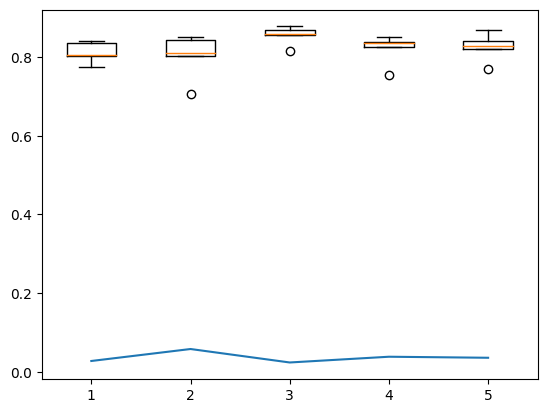

In [ ]:
plt.boxplot(df[df.columns]);
plt.plot([i for i in range(1, len(df.columns) + 1)], df.describe().transpose()["std"]);

We will show its mean and standar deviation too.

In [ ]:
df.describe().transpose()[["mean", "std"]]

,mean,std
0None,0.812303,0.027438
0.2None,0.803013,0.057874
0.4None,0.855308,0.023645
None0.2,0.822000,0.038252
None0.4,0.825872,0.035631


We save the results in order to plot them together.

In [ ]:
folds = [["RICAP" + r[0], *r[1]] for r in results.items()]
df = pd.read_csv("SSA_testing.csv")
_df = pd.DataFrame(folds, columns = df.columns)
df = pd.concat([df, _df])
df.to_csv("SSA_testing.csv", index = False)

Finally, we can plot an example of inference.

In [ ]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes)),
               get_items = get_image_files,
               get_y = get_y_fn,
               splitter = FuncSplitter(lambda x: Path(x).parent.name == "train"),
               item_tfms = [Resize((480,640)), TargetMaskConvertTransform()],
               batch_tfms = Normalize.from_stats(*imagenet_stats)
              )

dls = db.dataloaders(path_images, bs = 4)
learner = unet_learner(dls, **learner_hparams).to_fp16()
learner = learner.load("RICAP")

mask = learner.predict(dls.train_ds[6][0])
print(np.unique(mask[0]))
mask = PILImage.create(decodes(mask[0]))

/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruescog/.conda/envs/visionmodelsevaluation/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[0 1 2 3 4]


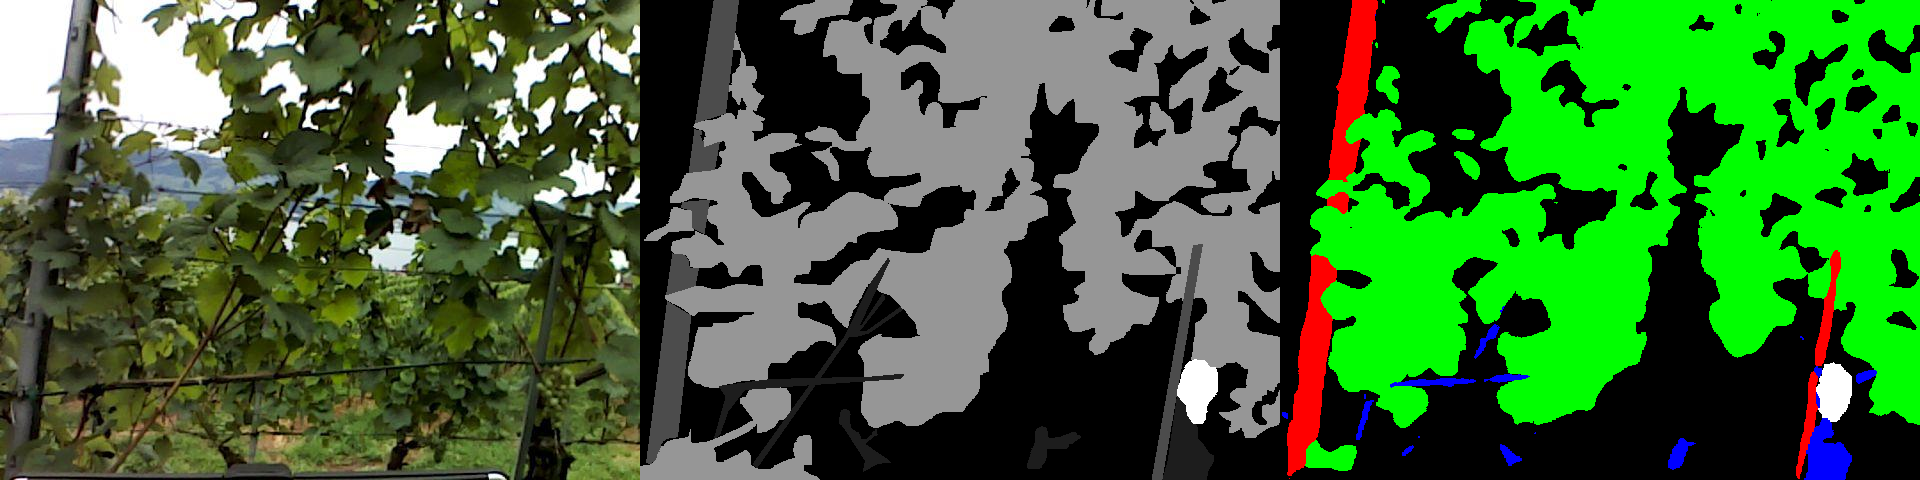

In [ ]:
image_grid([dls.train_ds[6][0], dls.train_ds[6][1], mask], rows = 1, cols = 3)

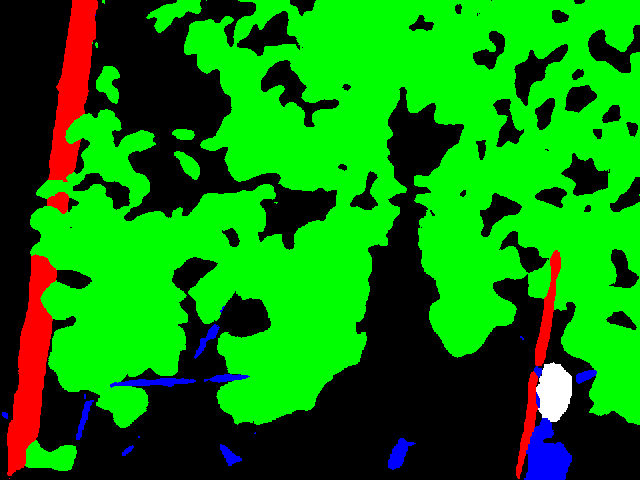

In [ ]:
mask